<a href="https://colab.research.google.com/github/albim72/MACHINE_DEEP_05/blob/main/analiza_tekstu_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
#analiza sentymentu
#pobieranie danych
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 3s 0us/step


In [5]:
os.listdir(dataset_dir)

['README', 'test', 'imdb.vocab', 'train', 'imdbEr.txt']

In [6]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'urls_unsup.txt',
 'unsup',
 'pos',
 'labeledBow.feat']

In [8]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f'Recenzja: {text_batch.numpy()[i]}')
    print(f"Etykieta: {label_batch.numpy()[i]}")

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [12]:
print(f"Etykieta 0 oznacza: {raw_train_ds.class_names[0]}")
print(f"Etykieta 1 oznacza: {raw_train_ds.class_names[1]}")

Etykieta 0 oznacza: neg
Etykieta 1 oznacza: pos


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size,
   )

Found 25000 files belonging to 2 classes.


In [18]:
#przygotowanie zbioru danych do treningu
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [20]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [21]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [23]:
text_batch,label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f"Recenzja: {first_review}")
print(f"Etykieta: {raw_train_ds.class_names[first_label]}")
print(f"Podgląd wektoryzacji tekstu: {vectorize_text(first_review,first_label)}")

Recenzja: b"I went to see Fever Pitch with my Mom, and I can say that we both loved it. It wasn't the typical romantic comedy where someone is pining for the other, and blah blah blah... You weren't waiting for the climatic first kiss or for them to finally get together. It was more real, because you saw them through the relationship, rather than the whole movie be about them getting together. People could actually relate to the film, because it didn't seem like extraordinary circumstances, or impossible situations. It was really funny, and I think it was Jimmy Fallon's best performance. All in all... I would definitely recommend it!"
Etykieta: pos
Podgląd wektoryzacji tekstu: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  426,    6,   67, 3775, 3322,   16,   54, 1611,    3,   10,
          68,  131,   12,   71,  192,  446,    9,    9,  269,    2,  769,
         736,  220,  114,  282,    7,    1,   15,    2,   78,    3, 2642,
        2642, 2642,   22, 1156, 1064,   15,

In [24]:
print(f"1287 --> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313--> {vectorize_layer.get_vocabulary()[313]}")
print(f"Rozmiar słownika: {len(vectorize_layer.get_vocabulary())}")

1287 --> silent
313--> night
Rozmiar słownika: 10000


In [25]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

**Stworzenie modelu.**
Wytrenowanie i ewaluacja

In [28]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [29]:
from tensorflow.python.ops.math_ops import truncate_mod
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

In [30]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 11s 15ms/step - loss: 0.6646 - binary_accuracy: 0.6920 - val_loss: 0.6162 - val_binary_accuracy: 0.7716
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.5495 - binary_accuracy: 0.7987 - val_loss: 0.4989 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.4451 - binary_accuracy: 0.8428 - val_loss: 0.4204 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3782 - binary_accuracy: 0.8658 - val_loss: 0.3737 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3353 - binary_accuracy: 0.8798 - val_loss: 0.3448 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3049 - binary_accuracy: 0.8884 - val_loss: 0.3256 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 6s 1

In [31]:
#ocena modelu
loss, accuracy = model.evaluate(test_ds)

print(f"Strata: {loss}")
print(f"Dokładność: {accuracy}")

782/782 [==============================] - 6s 7ms/step - loss: 0.3102 - binary_accuracy: 0.8734
Strata: 0.3102109730243683
Dokładność: 0.8734400272369385


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

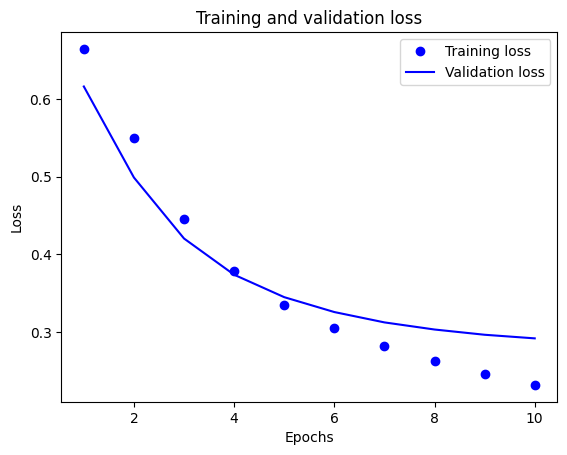

In [34]:
from tensorflow.python.ops.logging_ops import HistogramSummary
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

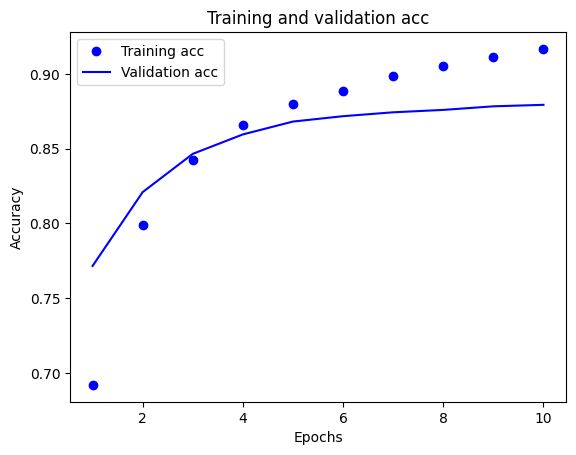

In [35]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
#Eksportowanie modelu, testy
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss = losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics = ['accuracy']
)

loss, accuracy =export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3102 - accuracy: 0.8734
0.8734400272369385


In [40]:
przyklady = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "The beautiful disaster!",
    "Super film",
    "bardzo fajny obraz..."
]
export_model.predict(przyklady)

1/1 [==============================] - 0s 41ms/step


array([[0.61999923],
       [0.4434988 ],
       [0.3602654 ],
       [0.5600875 ],
       [0.53280073],
       [0.5073218 ]], dtype=float32)